# STEP 1. NSMC 데이터 분석 및 Huggingface dataset 구성

In [160]:
import datasets
from datasets import load_dataset

dataset = load_dataset("nsmc")
print(dataset)

Using custom data configuration default
Reusing dataset nsmc (/aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3)


  0%|          | 0/2 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['id', 'document', 'label'],
        num_rows: 50000
    })
})


In [161]:
dataset['train']['document'][0]

'아 더빙.. 진짜 짜증나네요 목소리'

/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 54620 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44544 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 53581 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49828 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 53944 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/opt/conda/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 44600 missing from current font.
  font.set_

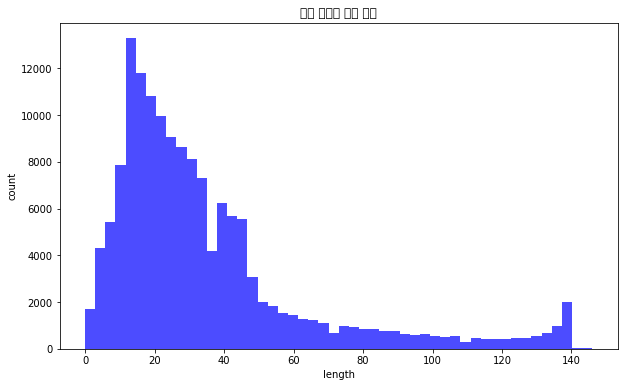

In [162]:
# train 데이터셋에서 'document' 열 추출
documents = dataset["train"]["document"]

# 한글 텍스트의 길이 측정
text_lengths = [len(text) for text in documents]

# 길이 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(text_lengths, bins=50, color='blue', alpha=0.7)
plt.title('한글 텍스트 길이 분포')
plt.xlabel('length')
plt.ylabel('count')
plt.show()

In [163]:
print(dataset["train"]["label"].count(0))
print(dataset["train"]["label"].count(1))

75173
74827


# STEP 2. klue/bert-base model 및 tokenizer 불러오기

In [164]:
import transformers
from transformers import AutoTokenizer, AutoModelForSequenceClassification

model_name = 'klue/bert-base'

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels = 2)

loading configuration file https://huggingface.co/klue/bert-base/resolve/main/config.json from cache at /aiffel/.cache/huggingface/transformers/fbd0b2ef898c4653902683fea8cc0dd99bf43f0e082645b913cda3b92429d1bb.99b3298ed554f2ad731c27cdb11a6215f39b90bc845ff5ce709bb4e74ba45621
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.11.3",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 32000
}

loading file https://huggingface.co/klue/bert-base/resolve/main/vocab.txt from cache at /aiffel/.cache/huggingface/transformers/1a36e69d48a0

# STEP 3. 위에서 불러온 tokenizer으로 데이터셋을 전처리하고, model 학습 진행해 보기

# STEP 4. Fine-tuning을 통하여 모델 성능(accuarcy) 향상시키기

- 데이터 전처리, TrainingArguments 등을 조정하여 모델의 정확도를 90% 이상으로 끌어올려봅시다.

In [165]:
def transform(data):
    return tokenizer(
        data['document'],
        truncation = True,
        padding = 'max_length',
        max_length = 40, # 140
        return_token_type_ids = False,
        )
dataset = dataset.map(transform, batched=True)
dataset

Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-12f6fa2c5c3ecf71.arrow
Loading cached processed dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-d97d4642b1141e81.arrow


DatasetDict({
    train: Dataset({
        features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
        num_rows: 150000
    })
    test: Dataset({
        features: ['attention_mask', 'document', 'id', 'input_ids', 'label'],
        num_rows: 50000
    })
})

In [166]:
# # 데이터 100개만 사용 
# data_cnt = 6000
# dateset_100 = dataset['train'].select(range(data_cnt))
# dataset['train'] = dateset_100
# dataset

In [167]:
# 토큰 길이 : paading 포함
len(dateset_100['input_ids'][0])

140

In [168]:
# train val 나누기
train_dataset = dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train'])*0.8)))
valid_dataset = dataset['train'].shuffle(seed=42).select(range(int(len(dataset['train'])*0.8),len(dataset['train'])))

# test
test_dataset = dataset['test']

print(len(train_dataset))
print(len(valid_dataset))
print(len(test_dataset))

Loading cached shuffled indices for dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-1ee25a1d2486862c.arrow
Loading cached shuffled indices for dataset at /aiffel/.cache/huggingface/datasets/nsmc/default/1.1.0/bfd4729bf1a67114e5267e6916b9e4807010aeb238e4a3c2b95fbfa3a014b5f3/cache-1ee25a1d2486862c.arrow


120000
30000
50000


In [169]:
import os
import numpy as np
from transformers import Trainer, TrainingArguments

output_dir = os.getenv('HOME')+'/aiffel/huggingface/checkpoint_alldata_maxlen40'

training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 4,   # 각 device 당 batch size
    per_device_eval_batch_size = 4,    # evaluation 시에 batch size
    num_train_epochs = 1,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
    save_steps = 1000,  # 원하는 체크포인트 저장 간격 설정 (예: 100, 200 등)
    save_total_limit=5,

)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [170]:
from datasets import load_metric
metric = load_metric('glue', 'mrpc')

def compute_metrics(eval_pred):    
    predictions,labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references = labels)

In [171]:
import torch
torch.cuda.empty_cache()

import gc
gc.collect()

6006

In [158]:
trainer = Trainer(
    model=model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset = train_dataset,    # training dataset
    eval_dataset = valid_dataset,       # evaluation dataset
    
    compute_metrics=compute_metrics,
)
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 120000
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 30000


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.394100,0.397361,0.897433,0.897238


Saving model checkpoint to /aiffel/aiffel/huggingface/checkpoint_alldata_maxlen40/checkpoint-1000
Configuration saved in /aiffel/aiffel/huggingface/checkpoint_alldata_maxlen40/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/huggingface/checkpoint_alldata_maxlen40/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/huggingface/checkpoint_alldata_maxlen40/checkpoint-2000
Configuration saved in /aiffel/aiffel/huggingface/checkpoint_alldata_maxlen40/checkpoint-2000/config.json
Model weights saved in /aiffel/aiffel/huggingface/checkpoint_alldata_maxlen40/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/huggingface/checkpoint_alldata_maxlen40/checkpoint-3000
Configuration saved in /aiffel/aiffel/huggingface/checkpoint_alldata_maxlen40/checkpoint-3000/config.json
Model weights saved in /aiffel/aiffel/huggingface/checkpoint_alldata_maxlen40/checkpoint-3000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/huggingfac

TrainOutput(global_step=30000, training_loss=0.43557698415120444, metrics={'train_runtime': 2720.7858, 'train_samples_per_second': 44.105, 'train_steps_per_second': 11.026, 'total_flos': 2466666144000000.0, 'train_loss': 0.43557698415120444, 'epoch': 1.0})

In [159]:
trainer.evaluate(test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 4


{'eval_loss': 0.3988664746284485,
 'eval_accuracy': 0.89784,
 'eval_f1': 0.8984331504016543,
 'eval_runtime': 168.4364,
 'eval_samples_per_second': 296.848,
 'eval_steps_per_second': 74.212,
 'epoch': 1.0}

- train : 30000, max_len : 140, 학습시간 : 110분
    - 근데 왜 학습할 땐, 30000 이라고 뜨지? : per_device_train_batch_size 영향인듯 

|Epoch|	Training Loss|	Validation Loss	|Accuracy|	F1|
|:---:|:---:|:---:|:---:|:---:|
|1|	0.399100|	0.387210|	🧷`0.901000`🧷|	0.900974|

{'eval_loss': 0.39205992221832275,    
 'eval_accuracy': `0.89954`,  
 
 'eval_f1': 0.9002363502750799,    
 'eval_runtime': 456.5871,  
 'eval_samples_per_second': 109.508,  
 'eval_steps_per_second': 27.377,  
 'epoch': 1.0}  
 
---

- train : 30000, max_len : 40, 학습시간 : 43분

|Epoch|	Training Loss|	Validation Loss	|Accuracy|	F1|
|:---:|:---:|:---:|:---:|:---:|
|1|	0.394100|	0.397361|	0.897433|	0.897238|

{'eval_loss': 0.3988664746284485,  
 'eval_accuracy': `0.89784`,  
 
 'eval_f1': 0.8984331504016543,  
 'eval_runtime': 168.4364,  
 'eval_samples_per_second': 296.848,  
 'eval_steps_per_second': 74.212,  
 'epoch': 1.0}  

---

- data : 6000개, Max_length : 512 , 학습시간 : 44분

|Epoch|	Training Loss|	Validation Loss	|Accuracy|	F1|
|:---:|:---:|:---:|:---:|:---:|
|1|	0.404800|	0.429618|	0.881833|	0.880860|

{'eval_loss': 0.4197678864002228,  
 'eval_accuracy': 0.87954,  
 'eval_f1': 0.8789565706706325,  
 'eval_runtime': 1700.6425,  
 'eval_samples_per_second': 29.401,  
 'eval_steps_per_second': 7.35,  
 'epoch': 1.0}  


## 결론

### 1. document 데이터의 텍스트 길이가 140 이하임을 확인하고, 불필요한 max_len을 줄였더니 성능이 향상함

### 2. 데이터 개수에 따른 성능이 차이남 (많을 수록 좋음), 단 학습 속도가 지나치게 느려져서 합의점 필요

### 3. max_len 140 vs 40 비교 결과, 성능 면에서는 140이 좋지만 미세한 차이임. 즉, 학습 속도가 유리한 40을 위주로 STEP 5을 진행함

# STEP 5. Bucketing을 적용하여 학습시키고, STEP 4의 결과와의 비교

```
아래 링크를 바탕으로 bucketing과 dynamic padding이 무엇인지 알아보고, 이들을 적용하여 model을 학습시킵니다.

Data Collator

Trainer.TrainingArguments 의 group_by_length

STEP 4에 학습한 결과와 bucketing을 적용하여 학습시킨 결과를 비교해보고, 모델 성능 향상과 훈련 시간 두 가지 측면에서 각각 어떤 이점이 있는지 비교해봅시다.
```

In [172]:
import os
import numpy as np
from transformers import Trainer, TrainingArguments
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from datasets import load_dataset


output_dir = os.getenv('HOME')+'/aiffel/huggingface/checkpoints_bucketing'

# 데이터 콜레이터
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

training_arguments = TrainingArguments(
    output_dir,                                         # output이 저장될 경로
    evaluation_strategy="epoch",           #evaluation하는 빈도
    learning_rate = 2e-5,                         #learning_rate
    per_device_train_batch_size = 4,   # 각 device 당 batch size
    per_device_eval_batch_size = 4,    # evaluation 시에 batch size
    num_train_epochs = 1,                     # train 시킬 총 epochs
    weight_decay = 0.01,                        # weight decay
    save_steps = 1000,  # 원하는 체크포인트 저장 간격 설정 (예: 100, 200 등)
    save_total_limit=5,
    
    group_by_length=True,  # Bucketing 활성화
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [173]:
trainer = Trainer(
    model=model,           # 학습시킬 model
    args=training_arguments,           # TrainingArguments을 통해 설정한 arguments
    train_dataset = train_dataset,    # training dataset
    eval_dataset = valid_dataset,       # evaluation dataset
    
    data_collator=data_collator,
    
    compute_metrics=compute_metrics,
)
trainer.train()

The following columns in the training set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running training *****
  Num examples = 120000
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 4
  Gradient Accumulation steps = 1
  Total optimization steps = 30000


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.386600,0.397512,0.896667,0.896777


Saving model checkpoint to /aiffel/aiffel/huggingface/checkpoints_bucketing/checkpoint-1000
Configuration saved in /aiffel/aiffel/huggingface/checkpoints_bucketing/checkpoint-1000/config.json
Model weights saved in /aiffel/aiffel/huggingface/checkpoints_bucketing/checkpoint-1000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/huggingface/checkpoints_bucketing/checkpoint-2000
Configuration saved in /aiffel/aiffel/huggingface/checkpoints_bucketing/checkpoint-2000/config.json
Model weights saved in /aiffel/aiffel/huggingface/checkpoints_bucketing/checkpoint-2000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/huggingface/checkpoints_bucketing/checkpoint-3000
Configuration saved in /aiffel/aiffel/huggingface/checkpoints_bucketing/checkpoint-3000/config.json
Model weights saved in /aiffel/aiffel/huggingface/checkpoints_bucketing/checkpoint-3000/pytorch_model.bin
Saving model checkpoint to /aiffel/aiffel/huggingface/checkpoints_bucketing/checkpoint-4000
Configuration 

TrainOutput(global_step=30000, training_loss=0.4382775217692057, metrics={'train_runtime': 2695.1836, 'train_samples_per_second': 44.524, 'train_steps_per_second': 11.131, 'total_flos': 2466666144000000.0, 'train_loss': 0.4382775217692057, 'epoch': 1.0})

In [174]:
trainer.evaluate(test_dataset)

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: id, document.
***** Running Evaluation *****
  Num examples = 50000
  Batch size = 4


{'eval_loss': 0.3995944857597351,
 'eval_accuracy': 0.89736,
 'eval_f1': 0.8981584378472773,
 'eval_runtime': 168.1401,
 'eval_samples_per_second': 297.371,
 'eval_steps_per_second': 74.343,
 'epoch': 1.0}

## STEP 5 결론


- 공동 조건 : train : 30000, max_len : 40, 
    - 일반 학습
        - 학습시간 : 43분, Valid Acc : 0.897433, Valid F1 : 0.897238, Eval Acc : 0.89784, Eval F1 : 0.898433
    - bucketing
        - 학습시간 : 43분, Valid Acc : 0.896667, Valid F1 : 0.896777, Eval Acc : 0.89736, Eval F1 : 0.898158
        
        
        
### 1. Bucketing + DataCollatorWithPadding을 사용하면 성능이 떨어지나, 큰 차이가 없다. 
### 이유 : 시퀀스 길이 분포와 max_length 설정이 잘 맞아 떨어져서 성능에 큰 차이가 없는 것으로 보인다. 아무래도 max_len이 40으로 매우 적은 시퀀스 길이 분포를 유지하며, 대부분의 데이터가 시퀀스 길이가 비슷함에 따라 성능에 큰 차이가 없어 보인다.